## LeNet-5 Implementation

![LeNet Architecture](lenet.png)

Source: Yan LeCun

### Load the MNIST Data
Load the MNIST Data that comes pre-loaded with Tensorflow

In [1]:
# Imports
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("mnist_dataset/", one_hot=True, reshape=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print('Image shape: {}'.format(X_train[0].shape))
print('# Training samples: {}'.format(len(X_train)))
print('# Validation samples: {}'.format(len(X_validation)))
print('# Test samples: {}'.format(len(X_test)))

Extracting mnist_dataset/train-images-idx3-ubyte.gz
Extracting mnist_dataset/train-labels-idx1-ubyte.gz
Extracting mnist_dataset/t10k-images-idx3-ubyte.gz
Extracting mnist_dataset/t10k-labels-idx1-ubyte.gz
Image shape: (28, 28, 1)
# Training samples: 55000
# Validation samples: 5000
# Test samples: 10000


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).


In [2]:
# Pad images with 0s
X_train = np.pad(X_train, [[0,0], [2,2], [2,2], [0,0]], 'constant')
X_validation = np.pad(X_validation, [[0,0], [2,2], [2,2], [0,0]], 'constant')
X_test = np.pad(X_test, [[0,0], [2,2], [2,2], [0,0]], 'constant')

print('The updated Image shape is: {}'.format(X_train[0].shape))

The updated Image shape is: (32, 32, 1)


## Visualise the Data

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


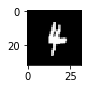

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])

## Preprocess the Data

In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Define the network hyper params

In [5]:
num_epochs = 10
batch_size = 128
learning_rate = 0.005
num_labels = 10

## Implement LeNet-5

In [6]:
images = tf.placeholder(tf.float32, shape=[None, 32, 32, 1])
labels = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

weights = {
    'c1': tf.Variable(tf.truncated_normal([5, 5, 1, 6])),
    'c2': tf.Variable(tf.truncated_normal([5, 5, 6, 16])),
    'fc1': tf.Variable(tf.truncated_normal([400, 120])),
    'fc2': tf.Variable(tf.truncated_normal([120, 84])),
    'out': tf.Variable(tf.truncated_normal([84, 10]))
}

biases = {
    'c1': tf.Variable(tf.truncated_normal([6])),
    'c2': tf.Variable(tf.truncated_normal([16])),
    'fc1': tf.Variable(tf.truncated_normal([120])),
    'fc2': tf.Variable(tf.truncated_normal([84])),
    'out': tf.Variable(tf.truncated_normal([10]))
}

def conv2d(input_vol, W, b, stride=1, padding='SAME'):
    conv_layer = tf.nn.conv2d(input_vol, W, strides=[1, stride, stride, 1], padding=padding)
    conv_layer = tf.nn.bias_add(conv_layer, b)
    conv_layer = tf.nn.relu(conv_layer)
    return conv_layer

def pool2d(input_vol, k=2, stride=2):
    return tf.nn.max_pool(input_vol, ksize=[1, k, k, 1], strides=[1, stride, stride, 1], padding='SAME')

def lenet(images, weights, biases, keep_probab):
    # CONV1 Input = [32x32x1] Output = [28x28x6]
    conv1 = conv2d(images, weights['c1'], biases['c1'], padding='VALID')
    
    # POOL1 Input = [28x28x6] Output = [14x14x6]
    pool1 = pool2d(conv1)
    
    # CONV2 Input = [14x14x6] Output = [10x10x16]
    conv2 = conv2d(pool1, weights['c2'], biases['c2'], padding='VALID')
    
    # POOL2 Input = [10x10x16] Output = [5x5x16]
    pool2 = pool2d(conv2)
    
    # FC1 Input = 400 Output = 120
    fc1 = tf.reshape(pool2, shape=[-1, weights['fc1'].get_shape().as_list()[0]])
    fc1 = tf.matmul(fc1, weights['fc1']) + biases['fc1']
    fc1 = tf.nn.relu(fc1)
    
    # FC2 Input = 120 Output = 84
    fc2 = tf.matmul(fc1, weights['fc2']) + biases['fc2']
    fc2 = tf.nn.relu(fc2)
    
    # OUT Input = 84 Output = 10
    out = tf.matmul(fc2, weights['out']) + biases['out']
    return out

## Training Pipeline

In [7]:
logits = lenet(images, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)\
                .minimize(cost)

## Model evaluation

In [8]:
correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    session = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset: offset+batch_size], y_data[offset: offset+batch_size]
        data_accuracy = session.run(accuracy, feed_dict={
            images: batch_x,
            labels: batch_y,
            keep_prob: 1.0
        })
        total_accuracy += (data_accuracy * batch_size)
    return total_accuracy / num_examples

## Train the Model

In [9]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print('Training...')
    num_examples = len(X_train)
          
    for epoch_i in range(num_epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            session.run(optimiser, feed_dict={images: batch_x, labels: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(epoch_i))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(session, 'lenet_ckpts/lenet.ckpt')
    print("Model saved")

Training...
EPOCH 0 ...
Validation Accuracy = 0.892

EPOCH 1 ...
Validation Accuracy = 0.943

EPOCH 2 ...
Validation Accuracy = 0.952

EPOCH 3 ...
Validation Accuracy = 0.971

EPOCH 4 ...
Validation Accuracy = 0.973

EPOCH 5 ...
Validation Accuracy = 0.971

EPOCH 6 ...
Validation Accuracy = 0.977

EPOCH 7 ...
Validation Accuracy = 0.981

EPOCH 8 ...
Validation Accuracy = 0.986

EPOCH 9 ...
Validation Accuracy = 0.989

Model saved


## Evaluate the Model

In [10]:
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('lenet_ckpts/'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from lenet_ckpts/lenet.ckpt
Test Accuracy = 0.974
